<a href="https://colab.research.google.com/github/Nicohim87/DeepLearning/blob/main/Pertemuan9/session9_GSLC2LEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [187]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import time
from IPython.display import clear_output


In [188]:
BUFFER_SIZE = 60000
BATCH_SIZE = 400

In [189]:
(trainX, trainY), (testX, testY) = mnist.load_data()

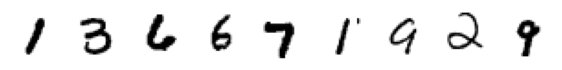

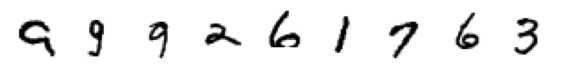

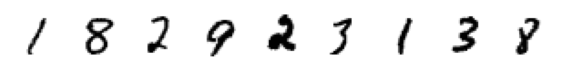

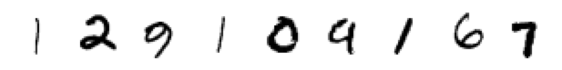

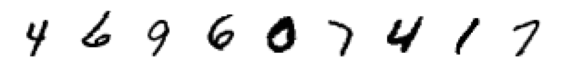

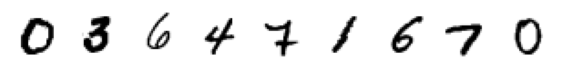

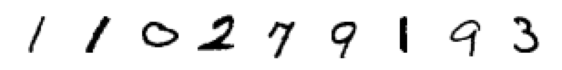

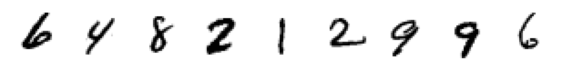

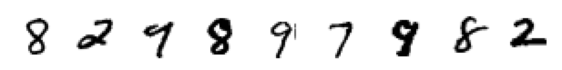

In [190]:
for k in range(9):
    plt.figure(figsize=(7, 7))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        plt.axis('off')
    plt.show()

In [191]:
trainX = [image/255.0 for image in trainX]
testX = [image/255.0 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

trainX = tf.data.Dataset.from_tensor_slices(trainX).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Generator

In [192]:
def generator_model():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7,7,256)),

        layers.Conv2DTranspose(128, kernel_size = (5, 5), strides = (1, 1), padding = 'same', use_bias = False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, kernel_size = (5, 5), strides = (2, 2), padding = 'same', use_bias = False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(16, kernel_size = (5, 5), strides = (1, 1), padding = 'same', use_bias = False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, kernel_size = (5, 5), strides = (2, 2), padding = 'same', use_bias = False, activation='sigmoid')
    ])

    assert model.output_shape == (None, 28, 28, 1)

    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


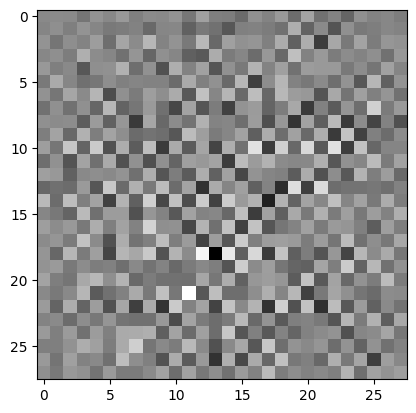

In [193]:
generator = generator_model()
noise = tf.random.normal([1,100])
generated_img = generator(noise, training=False)
plt.imshow(generated_img[0, :, :, 0], cmap='gray')

# Discriminator

In [194]:
def discriminator_model():
    model = tf.keras.Sequential([
        layers.Input((28, 28, 1)),
        layers.Conv2D(64, kernel_size=(5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(),

        layers.MaxPool2D(pool_size=(2,2)),
        layers.Dropout(0.3),

        layers.Conv2D(128, kernel_size=(5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(),

        layers.MaxPool2D(pool_size=(2,2)),
        layers.Dropout(0.3),

        layers.Flatten(),

        layers.Dense(128, activation='relu'),
        layers.Dense(32, activation='relu'),

        layers.Dropout(0.2),
        layers.Dense(8, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

In [195]:
discriminator = discriminator_model()
confidence = discriminator(generated_img, training=False)
print(confidence)

tf.Tensor([[0.5017642]], shape=(1, 1), dtype=float32)


# Loss Function

In [196]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [197]:
def generator_loss(fake_output):
    return loss_function(tf.ones_like(fake_output), fake_output)

In [198]:
def discriminator_loss(real_output, fake_output):
    real_loss = loss_function(tf.ones_like(real_output), real_output)
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)

    return real_loss + fake_loss

In [199]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training

In [200]:
EPOCHS = 50
NOISE_DIM = 100
NUM_EXAMPLE_TO_SHOW = 16

seed = tf.random.normal([NUM_EXAMPLE_TO_SHOW, NOISE_DIM])


In [201]:
@tf.function
def training(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        generated_image = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_image, training=True)

        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(real_output, fake_output)

    gradient_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_dis = dis_tape.gradient(dis_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradient_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradient_dis, discriminator.trainable_variables))

    return gen_loss, dis_loss

In [202]:
def generate_images(model, test_input):
    predictions = model(test_input, training=False)
    plt.figure(figsize=(5,5))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [203]:
def train(dataset, epochs):
    gen_losses = []
    dis_losses = []
    for epoch in range(epochs):
        start = time.time()

        epoch_gen_loss = []
        epoch_dis_loss = []

        for i, batch in enumerate(dataset):
            gen_loss, dis_loss = training(batch)
            epoch_gen_loss.append(gen_loss)
            epoch_dis_loss.append(dis_loss)

        gen_loss_ = sum(epoch_gen_loss)/len(epoch_gen_loss)
        dis_loss_ = sum(epoch_dis_loss)/len(epoch_dis_loss)
        gen_losses.append(gen_loss_)
        dis_losses.append(dis_loss_)

        clear_output(wait=True)
        generate_images(generator, seed)

        print(f'Epoch {epoch+1} - {time.time()-start} seconds, loss = {gen_loss_ + dis_loss_}, gen_loss = {gen_loss_}, dis_loss = {dis_loss_}')

    clear_output(wait=True)
    generate_images(generator, seed)

    return gen_losses, dis_losses

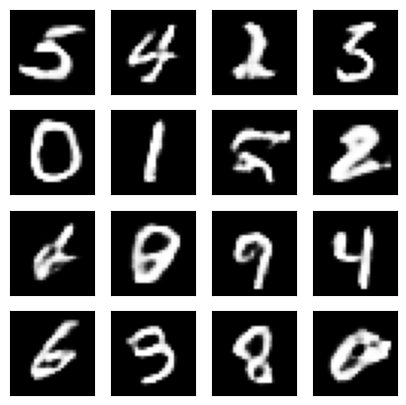

In [204]:
losses_g, losses_d = train(trainX, EPOCHS)

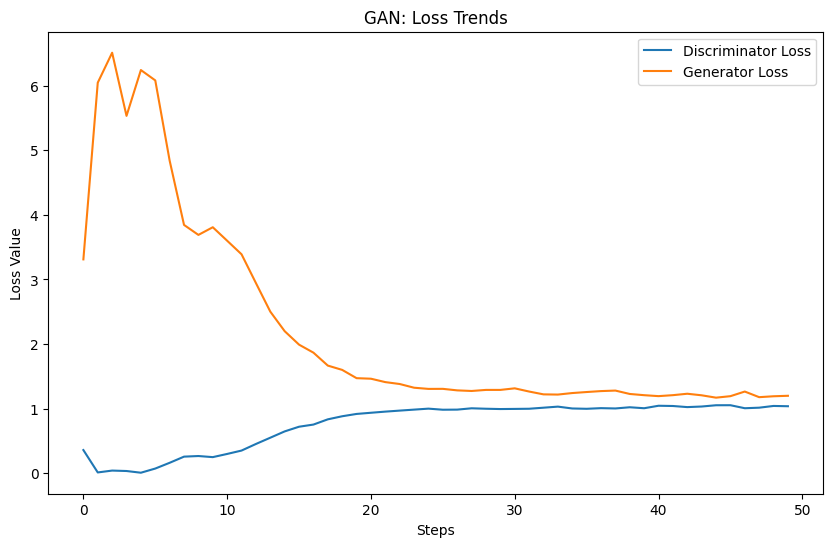

In [205]:
steps = [i for i in range(len(losses_d))]
plt.figure(figsize=(10, 6))
plt.plot(losses_d[:5000])
plt.plot(losses_g[:5000])
plt.xlabel('Steps')
plt.ylabel('Loss Value')
plt.title("GAN: Loss Trends")
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()